# Social Network Analysis applied to Data Warehouses

## 2. Network Connectivity Analysis: Out-Degree

The **degree** is simply the number of other nodes to which a node is adjacent ([Scott, 2017][Sco17]). In directed networks, such as those used in this research, _out-degree_ refers to the number of connections that proceed from a particular node, and _in-degree_ is the number of connections it receives. A node’s degree is the sum of its in-degree and out-degree. The present analysis considered only the out-degree because it represents the downstream dependencies for a given data asset. From this perspective, assets with higher out-degrees are considered more important because their absence might cause data pipelines to break and downstream assets to become obsolete.

[Sco17]: https://www.amazon.com/Social-Network-Analysis-John-Scott/dp/1473952123

### 2.1. Import dependencies

In [1]:
import itertools
import math
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.graph import Graph
import numpy as np
import pandas as pd
from pandas import Series

### 2.2. Utility functions

In [2]:
def load_graph_from_csv(file: str) -> Graph:
    return nx.read_edgelist(file, delimiter=",", create_using=nx.DiGraph)

In [3]:
def format_graph_info(graph_id: str, graph: Graph) -> str:
    return (
        f"{graph_id.upper()} GRAPH INFO:\n"
        f"  Number of nodes: {nx.number_of_nodes(graph)}\n"
        f"  Number of edges: {nx.number_of_edges(graph)}\n"
        f"  Density: {nx.density(graph)}\n"
        f"  Average clustering coefficient: {nx.average_clustering(graph)}\n"
        f"  Transitivity: {nx.transitivity(graph)}"
    )

In [4]:
def get_out_degree_list(graph: Graph) -> List[int]:
    return [degree for _, degree in graph.out_degree]

In [5]:
def get_out_degree_series(graph: Graph) -> Series:
    return pd.Series(get_out_degree_list(graph))

In [6]:
def draw_out_degree_based_network(graph: Graph) -> None:
    sorted_degrees = sorted(get_out_degree_list(graph))

    highest_degree = sorted_degrees[-1]
    scaling_factor = 3500 / highest_degree

    normalized_node_params = [
        (degree or 0.05) * scaling_factor for degree in sorted_degrees
    ]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        with_labels=False,
        edge_color="dimgray",
        node_color=normalized_node_params,
        node_size=normalized_node_params,
    )
    plt.axis("off")

In [7]:
def plot_out_degree_descriptive_stats(graph: Graph, color: str) -> None:
    degrees = get_out_degree_list(graph)

    plt.figure(figsize=(12, 3))
    plt.boxplot(degrees, vert=False, flierprops=dict(markerfacecolor=color))
    plt.xlabel("Out-degree")

In [8]:
def plot_out_degree_histogram(
    graph: Graph, color: str, start_from_degree: int = 0
) -> None:
    degrees = get_out_degree_list(graph)
    unique_degrees, counts = np.unique(degrees, return_counts=True)

    start_from_index = 0
    if start_from_degree:
        start_from_index = np.where(unique_degrees == start_from_degree)[0][0]

    plt.figure(figsize=(12, 3))
    plt.bar(unique_degrees[start_from_index:], counts[start_from_index:], color=color)
    plt.xlabel("Out-degree")
    plt.ylabel("# of Nodes")

In [9]:
def plot_out_degree_ranking(graph: Graph, fmt: str, stop_at_degree: int = 0) -> None:
    degrees = sorted(get_out_degree_list(graph), reverse=True)

    if stop_at_degree:
        stop_at_index = degrees.index(stop_at_degree)
        while degrees[stop_at_index] == degrees[stop_at_index + 1]:
            stop_at_index += 1

    adjusted_list = [None]
    adjusted_list.extend(degrees[: stop_at_index + 1] if stop_at_degree else degrees)

    plt.figure(figsize=(12, 3))
    plt.plot(adjusted_list, fmt)
    plt.xlabel("Rank")
    plt.ylabel("Out-degree")

In [10]:
def group_nodes_by_out_degree(
    graph: Graph, highest_first: bool = True
) -> Dict[int, List[str]]:
    degrees = get_out_degree_list(graph)
    unique_degrees = sorted(np.unique(degrees), reverse=highest_first)
    degrees_dict = {}
    for unique_degree in unique_degrees:
        degrees_dict[int(unique_degree)] = sorted(
            [node for node, degree in graph.out_degree if degree == unique_degree]
        )
    return degrees_dict

In [11]:
def get_out_degree_critical_nodes_for_count(
    graph: Graph, target_node_count
) -> Tuple[Dict[int, List[str]], float]:
    node_count = 0
    degree_groups = group_nodes_by_out_degree(graph)
    degree_sum = sum(get_out_degree_list(graph))

    group_count = 0
    while node_count < target_node_count:
        group_count += 1
        highest_degrees = dict(itertools.islice(degree_groups.items(), group_count))
        node_count = sum([len(nodes) for _, nodes in highest_degrees.items()])

    highest_degree_sum = sum(
        [degree * len(nodes) for degree, nodes in highest_degrees.items()]
    )
    groups_degree_ratio = highest_degree_sum / degree_sum * 100
    print(
        f"{group_count}-critical-groups node count: {node_count}\n"
        f"{group_count}-critical-groups/total out-degree ratio:"
        f" {groups_degree_ratio:.0f}% ({highest_degree_sum}/{degree_sum})"
    )

    return highest_degrees, node_count

In [12]:
def get_out_degree_critical_nodes_for_ratio(
    graph: Graph, target_ratio
) -> Tuple[Dict[int, List[str]], float]:
    groups_degree_ratio = 0
    degree_groups = group_nodes_by_out_degree(graph)
    degree_sum = sum(get_out_degree_list(graph))

    group_count = 0
    while groups_degree_ratio < target_ratio:
        group_count += 1
        highest_degrees = dict(itertools.islice(degree_groups.items(), group_count))
        highest_degree_sum = sum(
            [degree * len(nodes) for degree, nodes in highest_degrees.items()]
        )
        groups_degree_ratio = highest_degree_sum / degree_sum * 100

    node_count = sum([len(nodes) for _, nodes in highest_degrees.items()])

    print(
        f"{group_count}-critical-groups node count: {node_count}\n"
        f"{group_count}-critical-groups/total out-degree ratio:"
        f" {groups_degree_ratio:.0f}% ({highest_degree_sum}/{degree_sum})"
    )

    return highest_degrees, groups_degree_ratio

### 2.3. Load the anonymized graphs from CSV

In [13]:
anon_data_folder = "../data/anonymized"

small_graph_1 = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-small_1.csv")
print(f'{format_graph_info("small(1)", small_graph_1)}\n')

small_graph_2 = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-small_2.csv")
print(f'{format_graph_info("small(2)", small_graph_2)}\n')

medium_graph = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-medium.csv")
print(f'{format_graph_info("medium", medium_graph)}\n')

large_graph = load_graph_from_csv(f"{anon_data_folder}/anon-dataset-large.csv")
print(f'{format_graph_info("large", large_graph)}')

SMALL(1) GRAPH INFO:
  Number of nodes: 827
  Number of edges: 904
  Density: 0.0013233748400678083
  Average clustering coefficient: 0.008543182152613835
  Transitivity: 0.0034873583260680036

SMALL(2) GRAPH INFO:
  Number of nodes: 658
  Number of edges: 1400
  Density: 0.003238446840895107
  Average clustering coefficient: 0.12371040219915662
  Transitivity: 0.06696664902064585

MEDIUM GRAPH INFO:
  Number of nodes: 8298
  Number of edges: 9458
  Density: 0.00013737407751447794
  Average clustering coefficient: 0.005819181276085573
  Transitivity: 0.012780414150129421

LARGE GRAPH INFO:
  Number of nodes: 14511
  Number of edges: 24990
  Density: 0.00011868654882455435
  Average clustering coefficient: 0.04760245618981202
  Transitivity: 0.0035961744144591013


### 2.4. Draw the networks, degree histograms, and rankings

#### 2.4.1. Small network 1

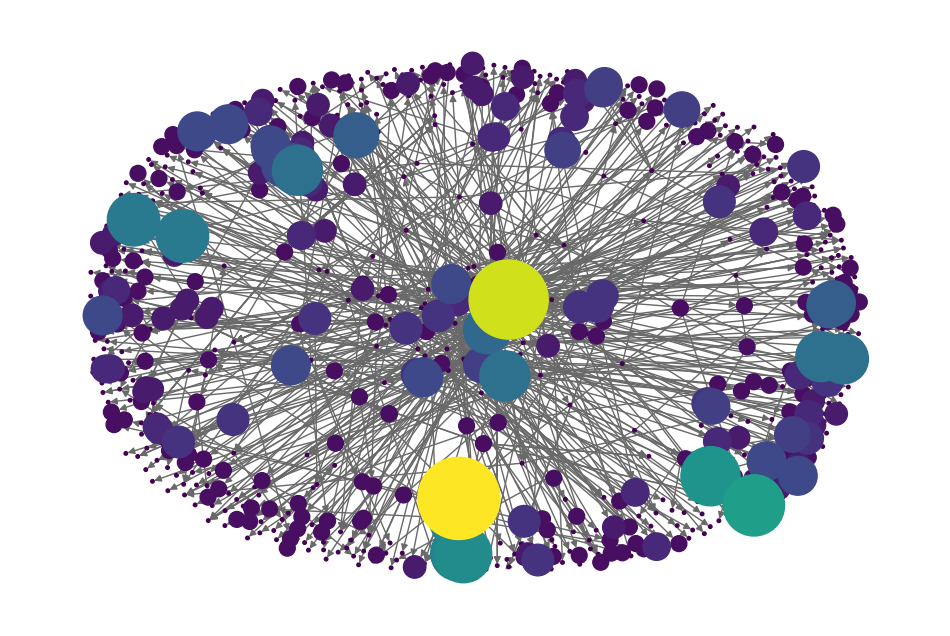

In [14]:
draw_out_degree_based_network(small_graph_1)

In [15]:
sg_1_out_degree_series = get_out_degree_series(small_graph_1)
print(sg_1_out_degree_series.describe())

count    827.000000
mean       1.093108
std        2.335076
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       27.000000
dtype: float64


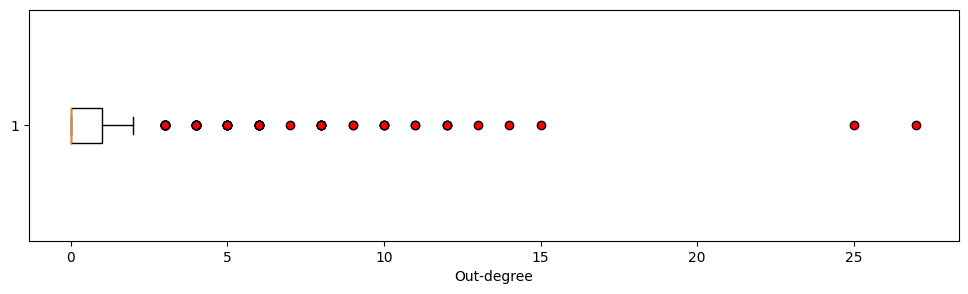

In [16]:
plot_out_degree_descriptive_stats(small_graph_1, "red")

A common fact among the four datasets is that there are few nodes with high out-degrees, as summarized by the above descriptive statistics and box plot chart. It means there is no clear threshold that can be used to determine what are the most important assets from the out-degree perspective.

Still, out-degree is a discrete metric, so the nodes can be grouped by their out-degrees and then ranked accordingly. The assets belonging to groups with higher out-degrees are the most relevant. The next chart brings a histogram showing the groups corresponding to the lower out-degrees, with higher node counts, at left, and the groups with the most important assets from the center to the right.

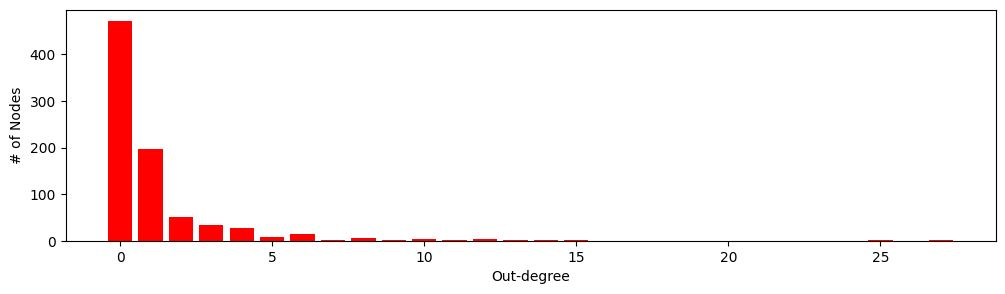

In [17]:
plot_out_degree_histogram(small_graph_1, "red")

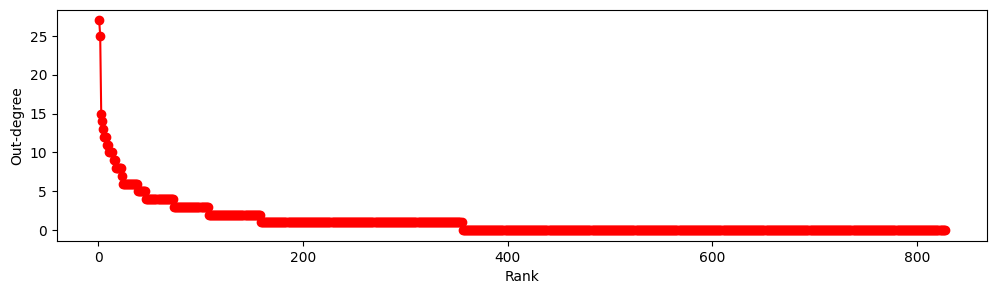

In [18]:
plot_out_degree_ranking(small_graph_1, "ro-")

The groups corresponding to ~20% of the total out-degrees were empirically selected to determine the most relevant assets. The results are presented in the next cells.

In [19]:
sg_1_critical_groups, _ = get_out_degree_critical_nodes_for_ratio(small_graph_1, 20)
print(f"\n{sg_1_critical_groups}")

sg_1_less_critical_out_degree = list(sg_1_critical_groups)[-1]

8-critical-groups node count: 14
8-critical-groups/total out-degree ratio: 21% (192/904)

{27: ['10007'], 25: ['10025'], 15: ['10060'], 14: ['10020'], 13: ['10131'], 12: ['10014', '10275', '10373'], 11: ['10059', '10115'], 10: ['10062', '10073', '10085', '10191']}


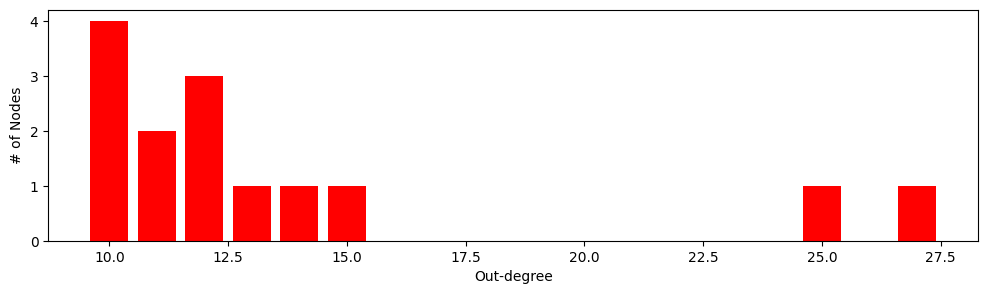

In [20]:
plot_out_degree_histogram(
    small_graph_1, "red", start_from_degree=sg_1_less_critical_out_degree
)

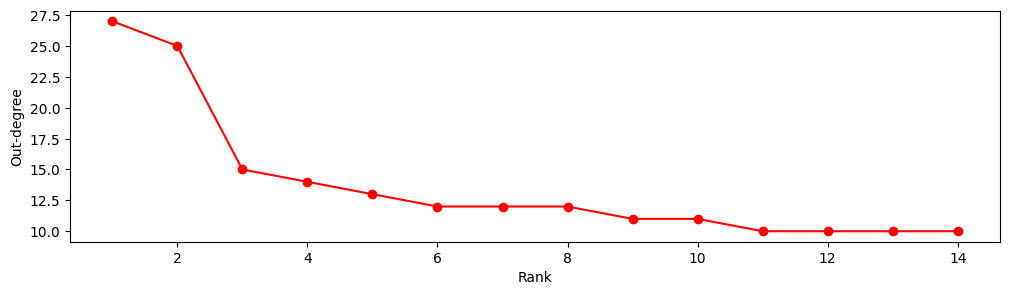

In [21]:
plot_out_degree_ranking(
    small_graph_1, "ro-", stop_at_degree=sg_1_less_critical_out_degree
)

In [22]:
# Only informative.

sg_1_critical_groups, _ = get_out_degree_critical_nodes_for_count(small_graph_1, 10)
print(f"\n{sg_1_critical_groups}")

7-critical-groups node count: 10
7-critical-groups/total out-degree ratio: 17% (152/904)

{27: ['10007'], 25: ['10025'], 15: ['10060'], 14: ['10020'], 13: ['10131'], 12: ['10014', '10275', '10373'], 11: ['10059', '10115']}


#### 2.4.2. Small network 2

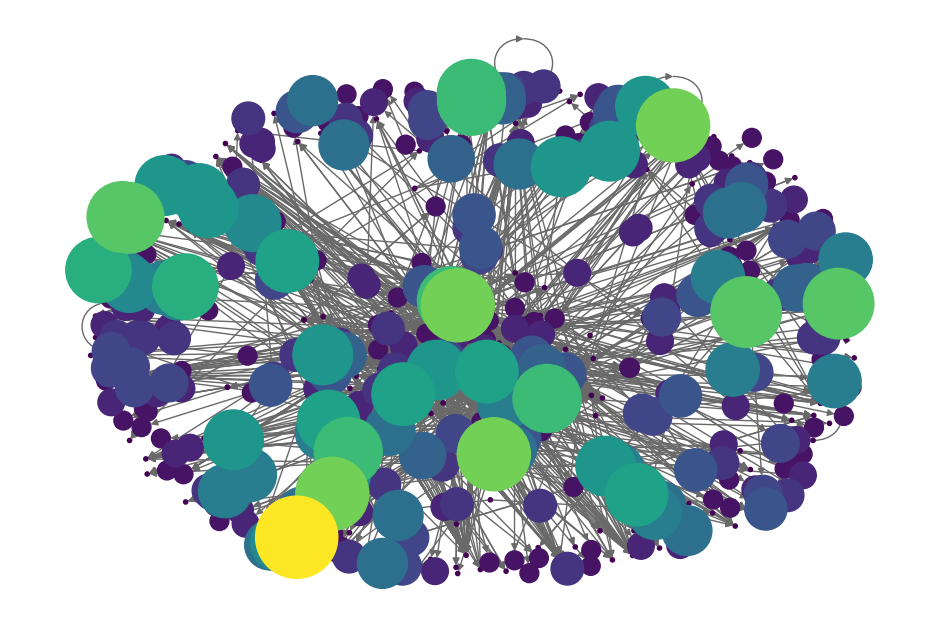

In [23]:
draw_out_degree_based_network(small_graph_2)

In [24]:
sg_2_out_degree_series = get_out_degree_series(small_graph_2)
print(sg_2_out_degree_series.describe())

count    658.000000
mean       2.127660
std        3.025834
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       19.000000
dtype: float64


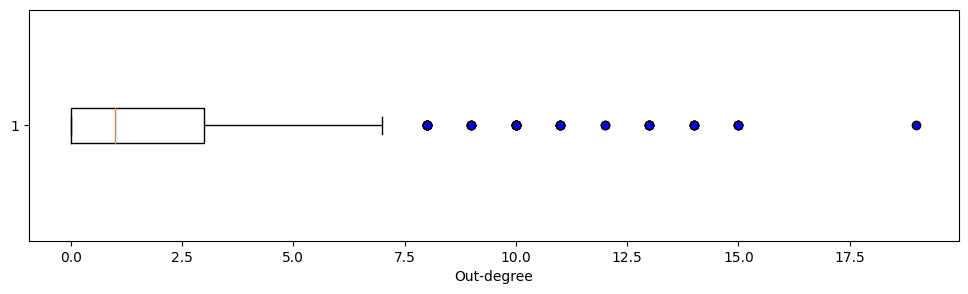

In [25]:
plot_out_degree_descriptive_stats(small_graph_2, "blue")

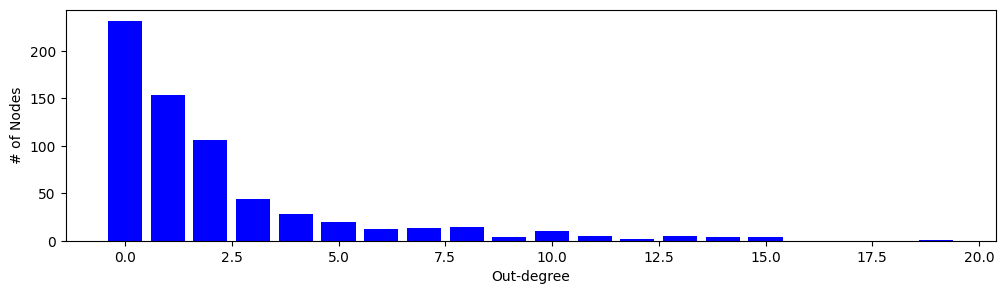

In [26]:
plot_out_degree_histogram(small_graph_2, "blue")

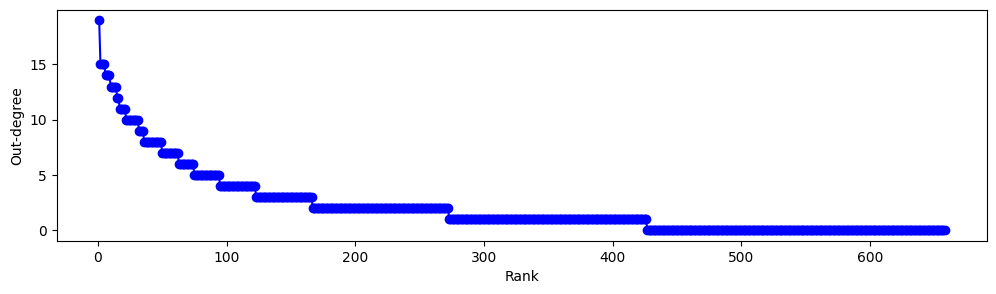

In [27]:
plot_out_degree_ranking(small_graph_2, "bo-")

In [28]:
sg_2_critical_groups, _ = get_out_degree_critical_nodes_for_ratio(small_graph_2, 20)
print(f"\n{sg_2_critical_groups}")

sg_2_less_critical_out_degree = list(sg_2_critical_groups)[-1]

7-critical-groups node count: 31
7-critical-groups/total out-degree ratio: 27% (379/1400)

{19: ['20026'], 15: ['20040', '20044', '20101', '20295'], 14: ['20071', '20110', '20214', '20349'], 13: ['20017', '20069', '20098', '20168', '20184'], 12: ['20174', '20332'], 11: ['20031', '20086', '20094', '20136', '20229'], 10: ['20012', '20030', '20049', '20074', '20109', '20145', '20158', '20283', '20350', '20379']}


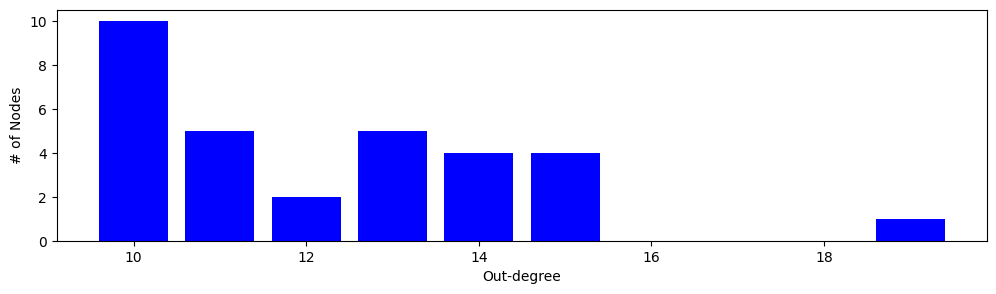

In [29]:
plot_out_degree_histogram(
    small_graph_2, "blue", start_from_degree=sg_2_less_critical_out_degree
)

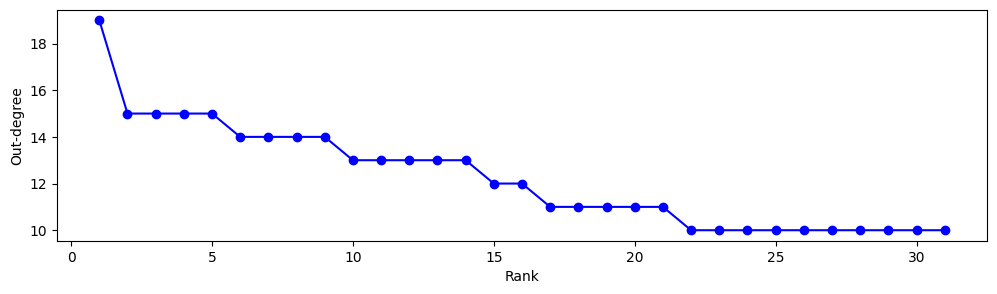

In [30]:
plot_out_degree_ranking(
    small_graph_2, "bo-", stop_at_degree=sg_2_less_critical_out_degree
)

In [31]:
# Only informative.

sg_2_critical_groups, _ = get_out_degree_critical_nodes_for_count(small_graph_2, 10)
print(f"\n{sg_2_critical_groups}")

4-critical-groups node count: 14
4-critical-groups/total out-degree ratio: 14% (200/1400)

{19: ['20026'], 15: ['20040', '20044', '20101', '20295'], 14: ['20071', '20110', '20214', '20349'], 13: ['20017', '20069', '20098', '20168', '20184']}


#### 2.4.3. Medium network

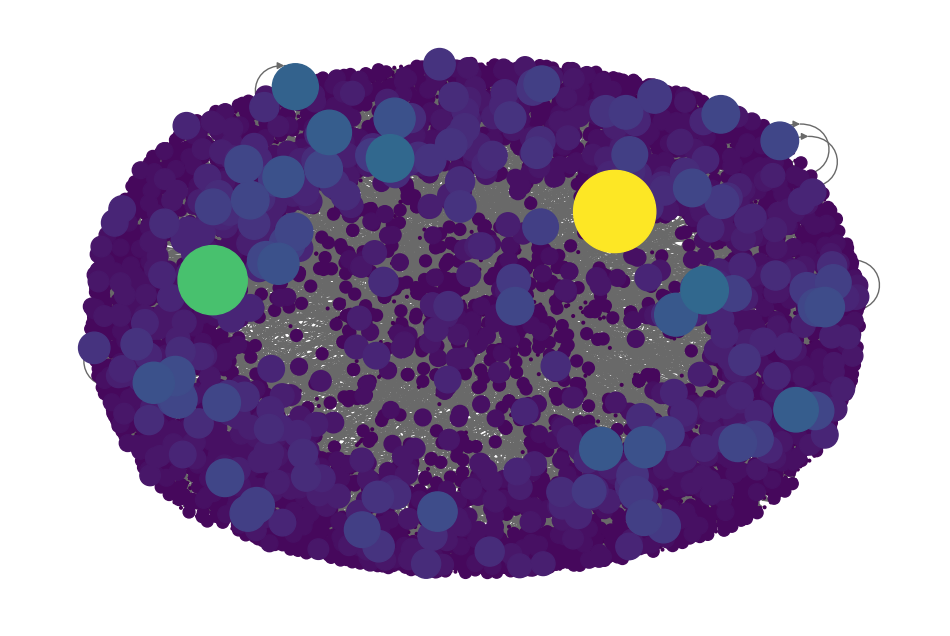

In [32]:
draw_out_degree_based_network(medium_graph)

In [33]:
mg_out_degree_series = get_out_degree_series(medium_graph)
print(mg_out_degree_series.describe())

count    8298.000000
mean        1.139793
std         1.440719
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        48.000000
dtype: float64


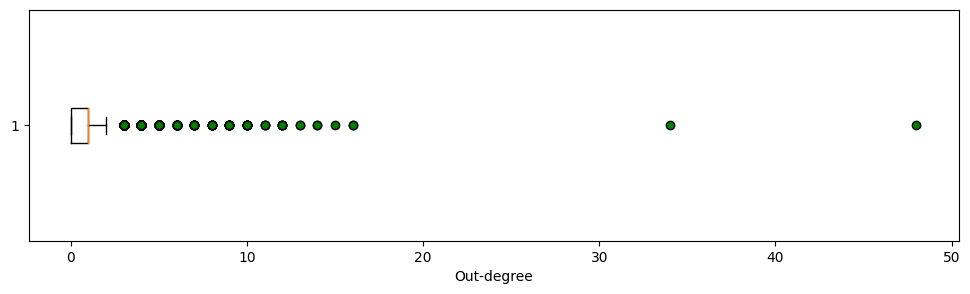

In [34]:
plot_out_degree_descriptive_stats(medium_graph, "green")

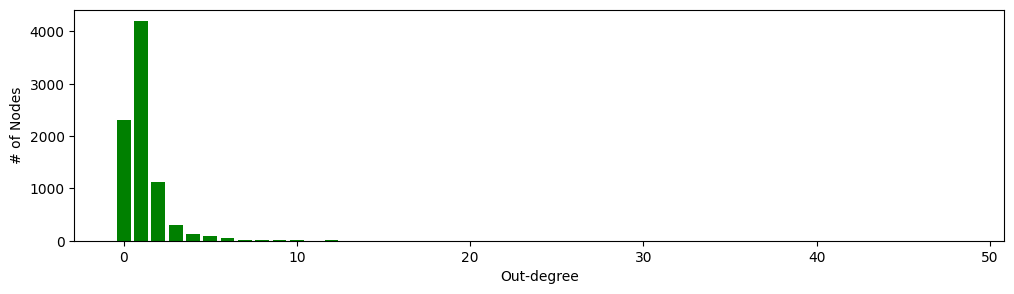

In [35]:
plot_out_degree_histogram(medium_graph, "green")

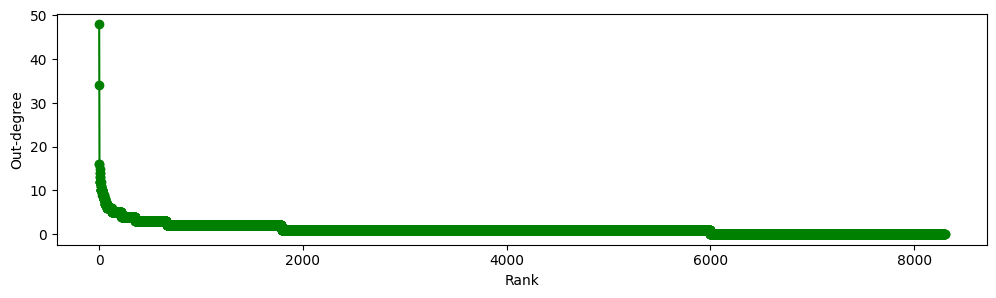

In [36]:
plot_out_degree_ranking(medium_graph, "go-")

In [37]:
mg_critical_groups, _ = get_out_degree_critical_nodes_for_ratio(medium_graph, 20)
print(f"\n{mg_critical_groups}")

mg_less_critical_out_degree = list(mg_critical_groups)[-1]

15-critical-groups node count: 354
15-critical-groups/total out-degree ratio: 22% (2074/9458)

{48: ['301958'], 34: ['300269'], 16: ['300076', '300576'], 15: ['301011'], 14: ['300191', '300346'], 13: ['300395', '300979'], 12: ['300078', '301618', '302271', '303001', '304266'], 11: ['300658', '302329', '303059'], 10: ['300310', '300324', '300423', '300546', '300834', '300873', '301062', '301776', '302040', '302118', '302268', '302314', '302490', '302822', '303505'], 9: ['300126', '300334', '300420', '300421', '301255', '301355', '301668', '301772', '302306', '302421', '302692', '302824', '302922'], 8: ['300183', '300255', '300312', '300350', '300603', '300751', '300755', '300813', '300889', '301726', '301863', '302640', '302696'], 7: ['300084', '300209', '300425', '300480', '300561', '300943', '300994', '301233', '301253', '301436', '301742', '301934', '302128', '302292', '302488', '302531', '302614', '302668'], 6: ['300034', '300072', '300088', '300171', '300189', '300200', '300247', '

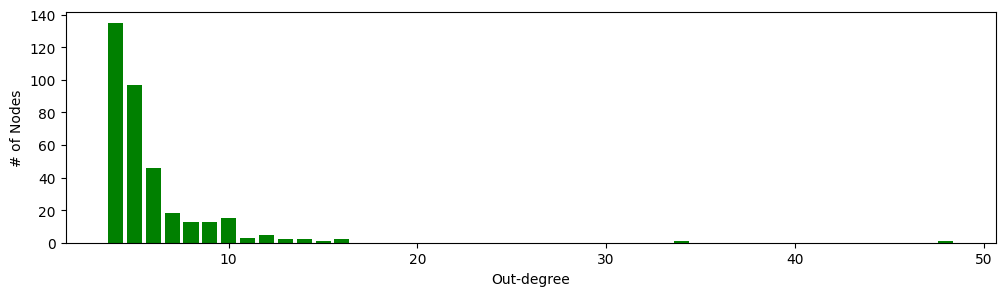

In [38]:
plot_out_degree_histogram(
    medium_graph, "green", start_from_degree=mg_less_critical_out_degree
)

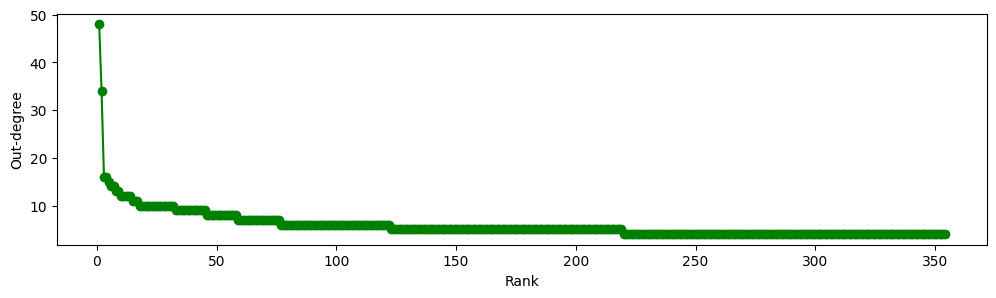

In [39]:
plot_out_degree_ranking(medium_graph, "go-", stop_at_degree=mg_less_critical_out_degree)

A slightly different approach will be used to select the most important assets for the _anon-dataset-medium_ and _anon-dataset-large_ datasets: a target asset count is specified instead of a percentage. This is because they contain way more assets than the small datasets and the ~20% percentage might return hundreds of assets, which is not helpful for Data Governance teams to act. 

In [40]:
mg_critical_groups, _ = get_out_degree_critical_nodes_for_count(medium_graph, 30)
print(f"\n{mg_critical_groups}")

mg_less_critical_out_degree = list(mg_critical_groups)[-1]

9-critical-groups node count: 32
9-critical-groups/total out-degree ratio: 5% (426/9458)

{48: ['301958'], 34: ['300269'], 16: ['300076', '300576'], 15: ['301011'], 14: ['300191', '300346'], 13: ['300395', '300979'], 12: ['300078', '301618', '302271', '303001', '304266'], 11: ['300658', '302329', '303059'], 10: ['300310', '300324', '300423', '300546', '300834', '300873', '301062', '301776', '302040', '302118', '302268', '302314', '302490', '302822', '303505']}


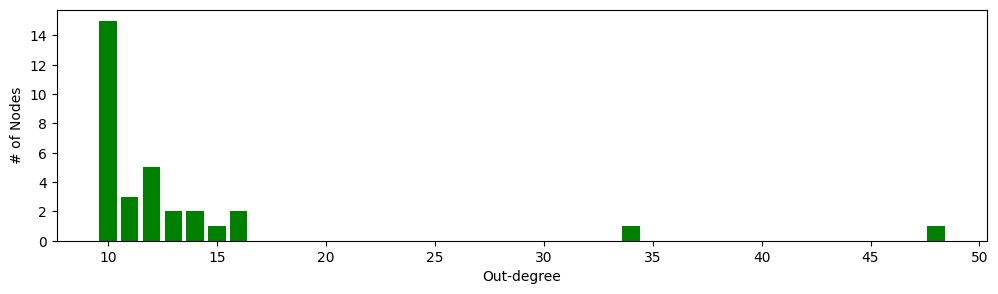

In [41]:
plot_out_degree_histogram(
    medium_graph, "green", start_from_degree=mg_less_critical_out_degree
)

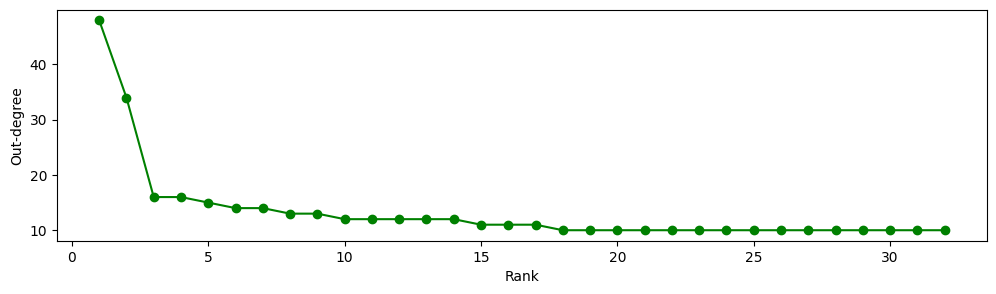

In [42]:
plot_out_degree_ranking(medium_graph, "go-", stop_at_degree=mg_less_critical_out_degree)

#### 2.4.4. Large network

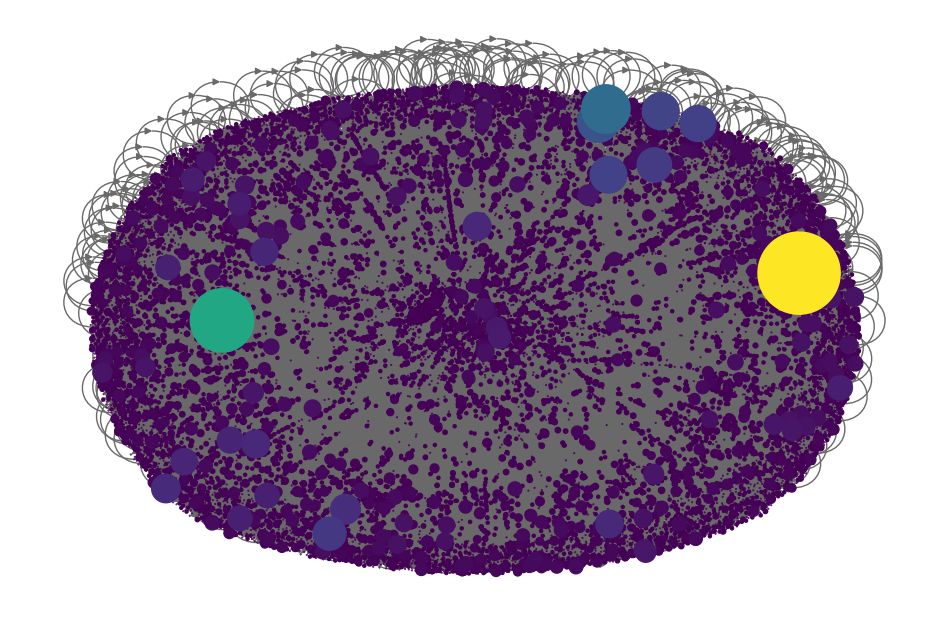

In [43]:
draw_out_degree_based_network(large_graph)

In [44]:
lg_out_degree_series = get_out_degree_series(large_graph)
print(lg_out_degree_series.describe())

count    14511.000000
mean         1.722142
std          8.368271
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        692.000000
dtype: float64


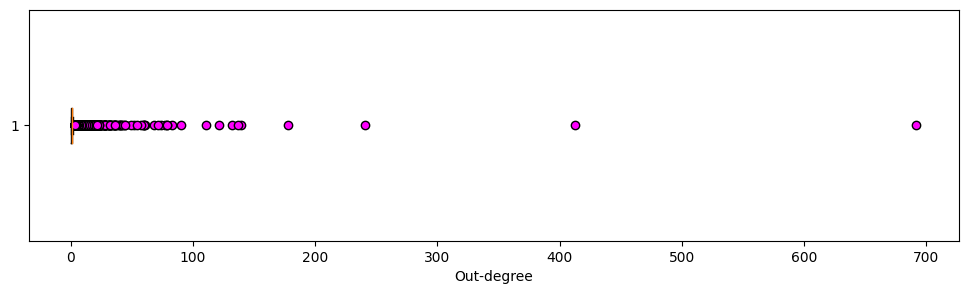

In [45]:
plot_out_degree_descriptive_stats(large_graph, "magenta")

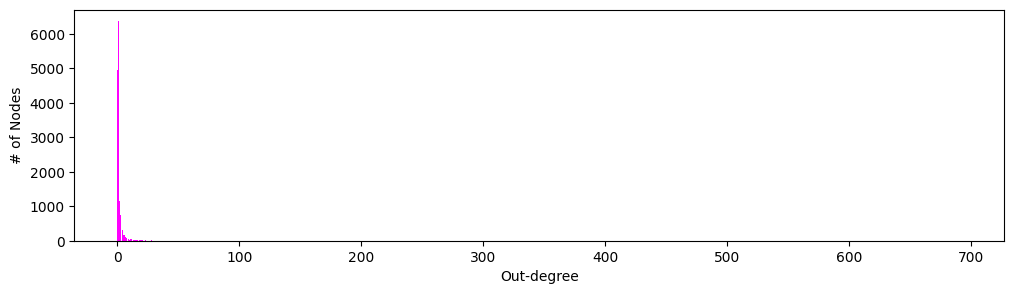

In [46]:
plot_out_degree_histogram(large_graph, "magenta")

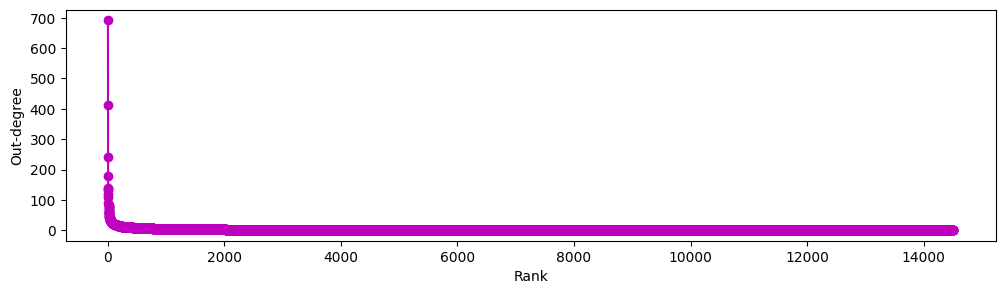

In [47]:
plot_out_degree_ranking(large_graph, "mo-")

In [48]:
lg_critical_groups, _ = get_out_degree_critical_nodes_for_ratio(large_graph, 20)
print(f"\n{lg_critical_groups}")

lg_less_critical_out_degree = list(lg_critical_groups)[-1]

46-critical-groups node count: 91
46-critical-groups/total out-degree ratio: 21% (5172/24990)

{692: ['4000092'], 413: ['4000064'], 241: ['4000015'], 178: ['4000044'], 139: ['4000766'], 137: ['4000270'], 132: ['4000272'], 121: ['4000109'], 111: ['4000995'], 90: ['4000312'], 83: ['4000562'], 79: ['4000144', '4000473'], 77: ['4000013'], 74: ['4000157'], 71: ['4000624'], 68: ['4000094'], 61: ['4000944'], 60: ['4000118', '4000487'], 59: ['4000492'], 57: ['4001442'], 54: ['4001822'], 52: ['4000329'], 49: ['4000426'], 44: ['4000017', '4001955'], 43: ['4001683'], 42: ['4000011'], 41: ['4000288'], 40: ['4000528', '4001400'], 39: ['4000286'], 38: ['4000909'], 37: ['4000957'], 36: ['4000039', '4000435', '4002734'], 35: ['4000200', '4001031', '4001540'], 34: ['4000388'], 33: ['4000777', '4000808'], 32: ['4000706', '4000860', '4002707'], 31: ['4000395', '4000830', '4001327'], 30: ['4000116', '4000697'], 29: ['4000359', '4001737'], 28: ['4000068', '4000196', '4000750', '4001783', '4002532', '400442

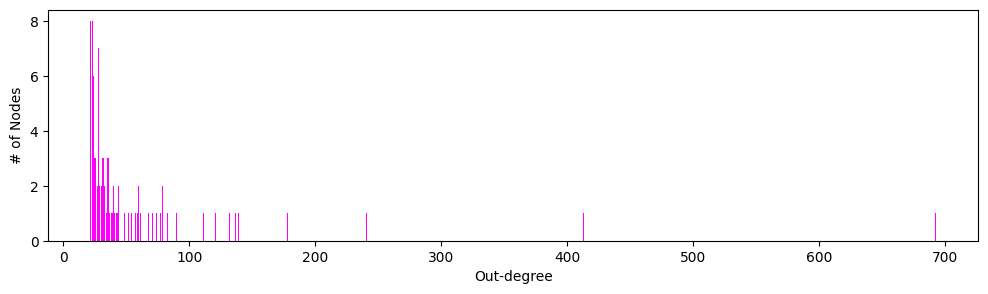

In [49]:
plot_out_degree_histogram(
    large_graph, "magenta", start_from_degree=lg_less_critical_out_degree
)

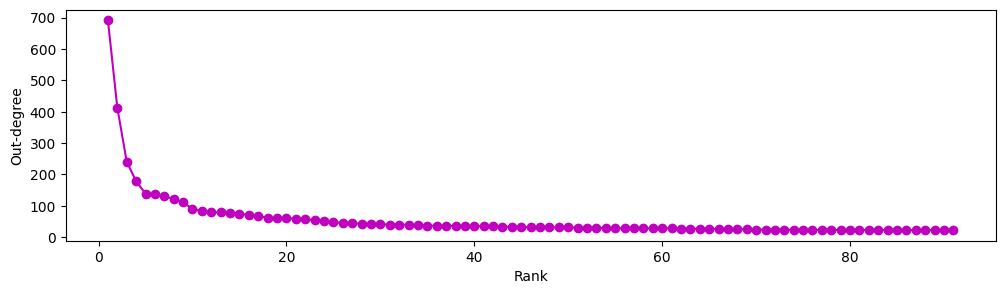

In [50]:
plot_out_degree_ranking(large_graph, "mo-", stop_at_degree=lg_less_critical_out_degree)

In [51]:
lg_critical_groups, _ = get_out_degree_critical_nodes_for_count(large_graph, 30)
print(f"\n{lg_critical_groups}")

lg_less_critical_out_degree = list(lg_critical_groups)[-1]

27-critical-groups node count: 30
27-critical-groups/total out-degree ratio: 14% (3451/24990)

{692: ['4000092'], 413: ['4000064'], 241: ['4000015'], 178: ['4000044'], 139: ['4000766'], 137: ['4000270'], 132: ['4000272'], 121: ['4000109'], 111: ['4000995'], 90: ['4000312'], 83: ['4000562'], 79: ['4000144', '4000473'], 77: ['4000013'], 74: ['4000157'], 71: ['4000624'], 68: ['4000094'], 61: ['4000944'], 60: ['4000118', '4000487'], 59: ['4000492'], 57: ['4001442'], 54: ['4001822'], 52: ['4000329'], 49: ['4000426'], 44: ['4000017', '4001955'], 43: ['4001683'], 42: ['4000011'], 41: ['4000288']}


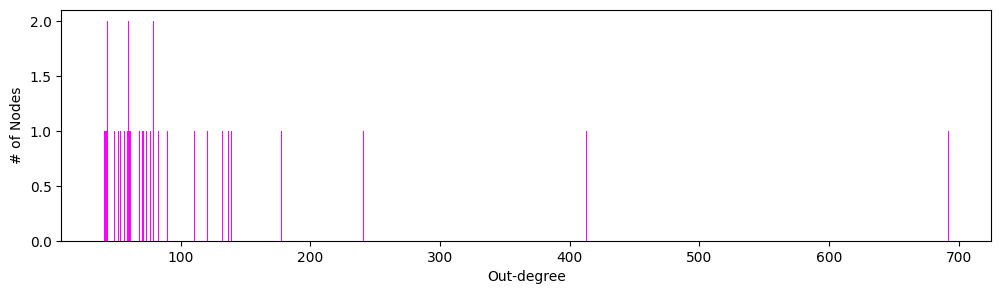

In [52]:
plot_out_degree_histogram(
    large_graph, "magenta", start_from_degree=lg_less_critical_out_degree
)

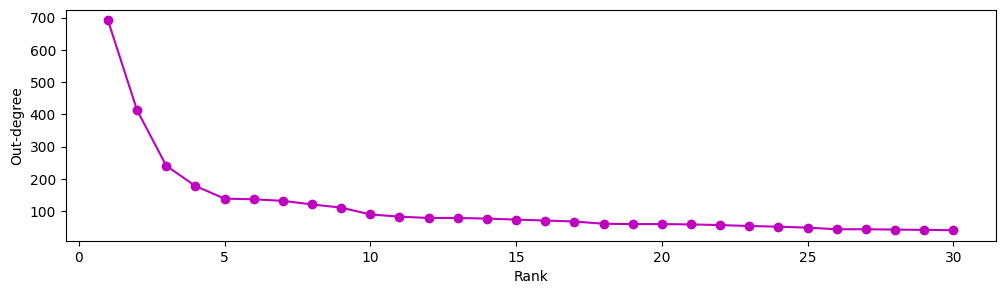

In [53]:
plot_out_degree_ranking(large_graph, "mo-", stop_at_degree=lg_less_critical_out_degree)